In [1]:
import os
import consts
import numpy as np
import pandas as pd
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.feature_selection import SelectKBest
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

In [2]:
# Time segment size in minutes
SEGMENT_SIZE = 15
TIME_SEGMENTS = list(range(0, 91, SEGMENT_SIZE))
pd.options.mode.copy_on_write = True

In [3]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)

    return scores


def get_number_of_players_per_pos(row):
    str_formation = str(row["formation"])
    num_defenders = int(str_formation[0])
    num_midfielders = sum([int(s) for s in str_formation[1:-1]])
    num_attackers = int(str_formation[-1])
    return num_defenders, num_midfielders, num_attackers

In [4]:
df_data_points = pd.read_csv(consts.DATA_POINTS_FILE_PATH)
df_match_kpi = pd.read_csv(consts.MATCH_KPI_FILE_PATH)
df_data_points = df_data_points.merge(df_match_kpi[["match_id", "team", "home_or_away"]], on=["match_id", "team"])
df_data_points["timestamp"] = pd.to_datetime(df_data_points["timestamp"])
df_data_points["minutes"] = df_data_points["timestamp"].apply(lambda t: t.hour * 60 + t.minute)
df_data_points["event_occurred"] = (df_data_points["type"] == "Shot") & (df_data_points.get("shot_outcome") == "Goal")

In [5]:
df_match_kpi.head(3)

,match_id,team,formation,opposing_team_formation,shot,pass,under_pressure,score,counterpress,formation_play_duration,formation_play_duration_ratio,shot_mean,pass_mean,under_pressure_mean,counterpress_mean,home_or_away,goals
0,3813279,Chennaiyin,352,4231,20,522,346,2,60,0 days 01:38:09.084000,1.0,20.0,522.0,346.0,60.0,1,3
1,3813279,Odisha,4231,352,9,369,279,1,38,0 days 01:38:09.084000,1.0,9.0,369.0,279.0,38.0,0,3
2,3813280,Chennaiyin,4141,4411,24,489,313,0,42,0 days 01:39:14.984000,1.0,24.0,489.0,313.0,42.0,1,0


In [6]:
df_data_points.head(3)

,index,team,timestamp,shot_outcome,type,formation,opposing_team_formation,formation_play_duration,goal_difference,number_of_goals,match_id,mean_expected_goals_per_game,home_or_away,minutes,event_occurred
0,0,Manchester City WFC,1900-01-01,NaN,Starting XI,433,352,0 days 00:48:02.900000,0,0,7298,0.220619,1,0,False
1,0,Manchester City WFC,1900-01-01,NaN,Starting XI,433,352,0 days 00:48:02.900000,0,0,7298,0.220619,1,0,False
2,1,Chelsea FCW,1900-01-01,NaN,Starting XI,352,433,0 days 00:05:46.380000,0,0,7298,0.325670,0,0,False


In [7]:
df_data_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37550 entries, 0 to 37549
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   index                         37550 non-null  int64         
 1   team                          37550 non-null  object        
 2   timestamp                     37550 non-null  datetime64[ns]
 3   shot_outcome                  10960 non-null  object        
 4   type                          37550 non-null  object        
 5   formation                     37550 non-null  int64         
 6   opposing_team_formation       37550 non-null  int64         
 7   formation_play_duration       37550 non-null  object        
 8   goal_difference               37550 non-null  int64         
 9   number_of_goals               37550 non-null  int64         
 10  match_id                      37550 non-null  int64         
 11  mean_expected_goals_per_game

In [8]:
df_match_kpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8044 entries, 0 to 8043
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   match_id                       8044 non-null   int64  
 1   team                           8044 non-null   object 
 2   formation                      8044 non-null   int64  
 3   opposing_team_formation        8044 non-null   int64  
 4   shot                           8044 non-null   int64  
 5   pass                           8044 non-null   int64  
 6   under_pressure                 8044 non-null   object 
 7   score                          8044 non-null   int64  
 8   counterpress                   8044 non-null   int64  
 9   formation_play_duration        8044 non-null   object 
 10  formation_play_duration_ratio  8044 non-null   float64
 11  shot_mean                      8043 non-null   float64
 12  pass_mean                      8044 non-null   f

In [9]:
original_features = ["team", "type", "formation", "opposing_team_formation", 
            "formation_play_duration", "goal_difference", "number_of_goals",
            "mean_expected_goals_per_game", "home_or_away", "minutes",
            "event_occurred"]
# Create a new DataFrame containing just the feature we are interested in.
df_data_points_main = df_data_points[original_features]

In the data points dataset there are There are 4 numerical features (formation_play_duration, goal_difference, number_of_goals and mean_expected_goals_per_game) and 5 categorical features (team, type, formation, opposing_team_formation and home_or_away (shot_outcome is related to the "Goal" type event and won't be used as a feature)).
Before we continue the categorical variables need to encoded to one-hot vectors.

In [10]:
# The home_or_away and event_occurred variable has just two possibles values, 1 or 0, therefore
# it won't be one-hot encoded.
categories = ["team", "type", "formation", "opposing_team_formation"]
df_data_points_main = pd.get_dummies(df_data_points_main, columns=categories)

In [11]:
df_data_points_main.head(3)

,formation_play_duration,goal_difference,number_of_goals,mean_expected_goals_per_game,home_or_away,minutes,event_occurred,team_AC Ajaccio,team_AC Milan,team_AFC Bournemouth,...,opposing_team_formation_4321,opposing_team_formation_4411,opposing_team_formation_5221,opposing_team_formation_32122,opposing_team_formation_32221,opposing_team_formation_41212,opposing_team_formation_41221,opposing_team_formation_42121,opposing_team_formation_42211,opposing_team_formation_312112
0,0 days 00:48:02.900000,0,0,0.220619,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0 days 00:48:02.900000,0,0,0.220619,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0 days 00:05:46.380000,0,0,0.325670,0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
features = np.setdiff1d(df_data_points_main.columns, ["event_occurred", "minutes"])

In [13]:
features

array(['formation_3142', 'formation_32221', 'formation_3232',
       'formation_3412', 'formation_3421', 'formation_343',
       'formation_3511', 'formation_352', 'formation_41212',
       'formation_41221', 'formation_4132', 'formation_4141',
       'formation_42121', 'formation_42211', 'formation_4222',
       'formation_4231', 'formation_4312', 'formation_4321',
       'formation_433', 'formation_4411', 'formation_442',
       'formation_451', 'formation_5221', 'formation_532',
       'formation_541', 'formation_play_duration', 'goal_difference',
       'home_or_away', 'mean_expected_goals_per_game', 'number_of_goals',
       'opposing_team_formation_312112', 'opposing_team_formation_3142',
       'opposing_team_formation_32122', 'opposing_team_formation_32221',
       'opposing_team_formation_3232', 'opposing_team_formation_3412',
       'opposing_team_formation_3421', 'opposing_team_formation_343',
       'opposing_team_formation_3511', 'opposing_team_formation_352',
       'oppo

In [14]:
# Check for null values and duplicated rows in the new dataset
num_null = sum(df_data_points_main[features].isnull().sum())
print(f"Found {num_null} null values in the dataset.")

print(len(df_data_points_main))
num_duplicates = sum(df_data_points_main.duplicated(keep="first"))
df_data_points_main = df_data_points_main.drop_duplicates(keep="first").reset_index(drop=True)
print(f"Found {num_duplicates} duplicates in the dataset.")

Found 0 null values in the dataset.
37550
Found 7349 duplicates in the dataset.


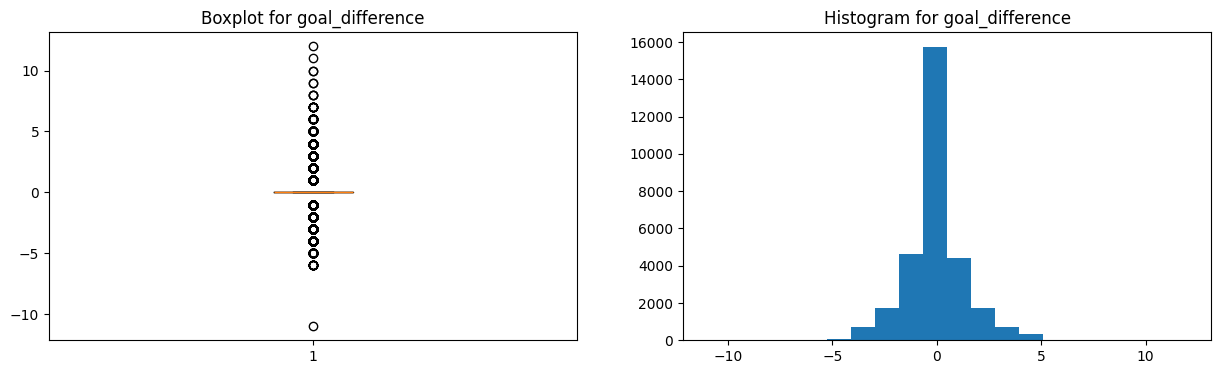

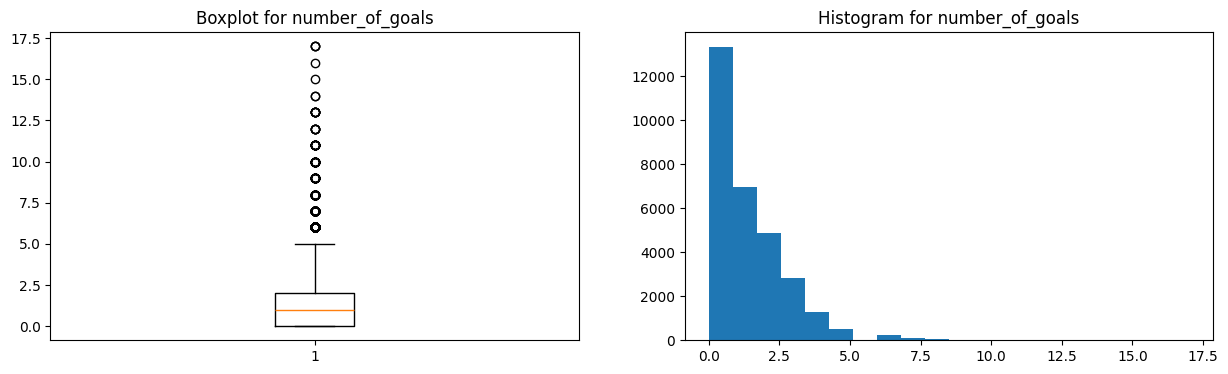

In [15]:
# Display the boxplot and histogram of selected number of numerical features.
selected_features = ["goal_difference", "number_of_goals"]

for feature in selected_features:
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))
    x = df_data_points_main[feature].values
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )
    plt.show()

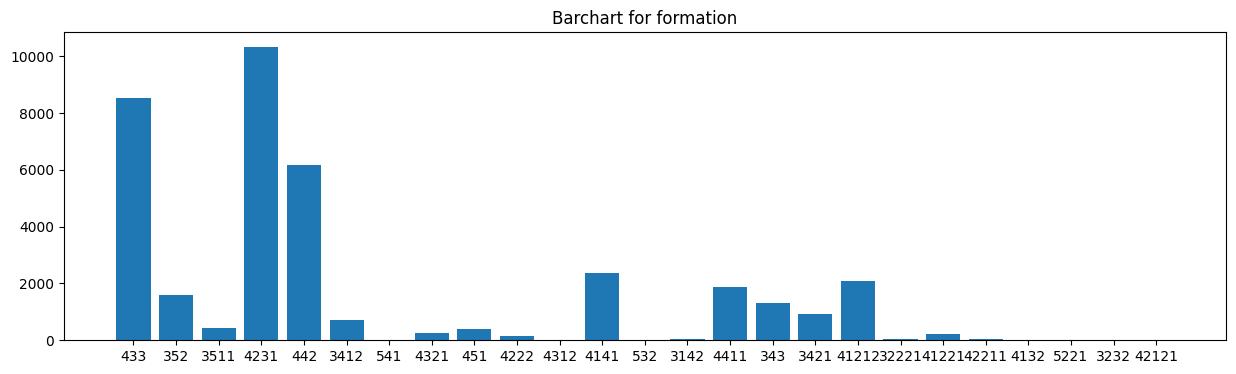

In [16]:
# Show formation category values.
from collections import Counter

for feature in ["formation"]:
    fig, ax = plt.subplots(figsize=(15, 4))
    x = df_data_points[feature].values
    data = Counter(x)
    category = list(str(k) for k in data.keys())
    counts = list(data.values())
    ax.bar(category, counts)
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

21138
9063


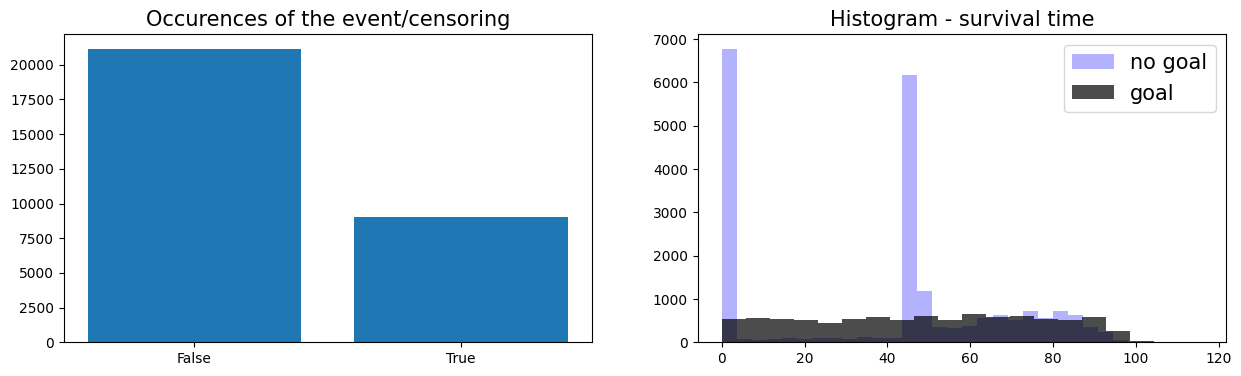

In [17]:
# Display occurrences of goal and non-goal (censored) events.
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(df_data_points_main["event_occurred"].replace({0:"no goal", 1:"goal"}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = df_data_points_main.loc[df_data_points_main["event_occurred"] == 0, "minutes"]
print(len(time_0))
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'no goal')

# Showing the histogram of the survival times for the events
time_1 = df_data_points_main.loc[df_data_points_main["event_occurred"] == 1, "minutes"]
print(len(time_1))
ax2.hist(time_1, bins=20, alpha=0.7, color="black", label="goal")
ax2.set_title("Histogram - survival time", fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

From the charts we can see that just over 40% of events are related to goal scoring events. It is less likely that the goal scoring event will occur in the first 5 minutes of the match and between 45-50th minute of the match.

<Axes: >

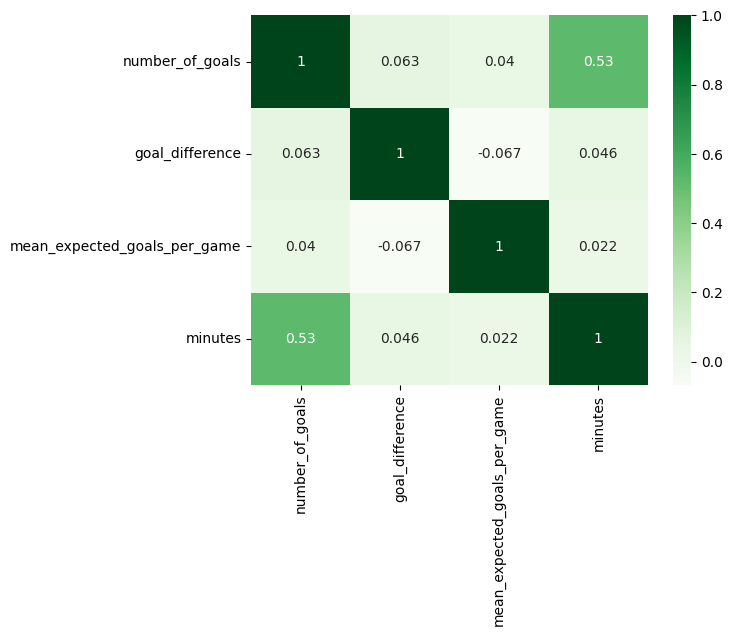

In [18]:
import seaborn as sns

# Compute and visualize correlation between different features.
correlation_matrix = df_data_points[["number_of_goals", "goal_difference", "mean_expected_goals_per_game", "minutes"]].corr()

sns.heatmap(correlation_matrix, cmap="Greens", annot=True)

In [19]:
event_features = ["event_occurred", "minutes"]
df_data_points_main = df_data_points[["event_occurred", "minutes", "team", "type", "formation", "opposing_team_formation", 
                                      "goal_difference", "number_of_goals", "formation_play_duration"]]
# Convert formation_play_duration from string to timedeltan and from timedelta to minutes. 
df_data_points_main["formation_play_duration_minute"] = pd.to_timedelta(df_data_points_main["formation_play_duration"])
df_data_points_main["formation_play_duration_minute"] = df_data_points_main["formation_play_duration_minute"].apply(lambda t: t.total_seconds()/60)
df_event_points = df_data_points_main[event_features].to_records(index=False)
df_data_points_main = pd.get_dummies(df_data_points_main, columns=categories)
# Drop target columns and the formation_play_duration feature from the features DataFrame.
df_data_points_main = df_data_points_main.drop(columns=event_features+["formation_play_duration"]).reset_index(drop=True)

x_train, x_test, y_train, y_test = train_test_split(df_data_points_main, df_event_points,
                                                    test_size=0.2, stratify=df_event_points["event_occurred"], 
                                                    random_state=0)

rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
    
rsf.fit(x_train, y_train)

RandomSurvivalForest(min_samples_leaf=7, random_state=0)

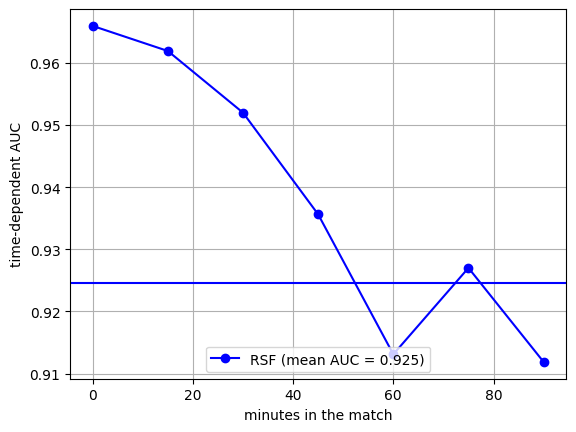

In [20]:
rsf_chf_func = rsf.predict_cumulative_hazard_function(x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(TIME_SEGMENTS) for chf in rsf_chf_func])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, TIME_SEGMENTS)

plt.plot(TIME_SEGMENTS, rsf_auc, "o-", color="blue", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.axhline(rsf_mean_auc, linestyle="-", color="blue")
plt.xlabel("minutes in the match")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
plt.show(block=True)

The chart shows that the model has good performance through the entire match duration for predicting the risk of taking a goal. The model shows the lowest prediction performance at around 60th minute and at the end of a match.

(0.5254191100096597, 2732681, 2452137, 1852822, 98173)
(0.39467903822423833, 1478916, 3887472, 1671252, 98173)
(0.6116278079842674, 3969926, 3067712, 2, 98173)


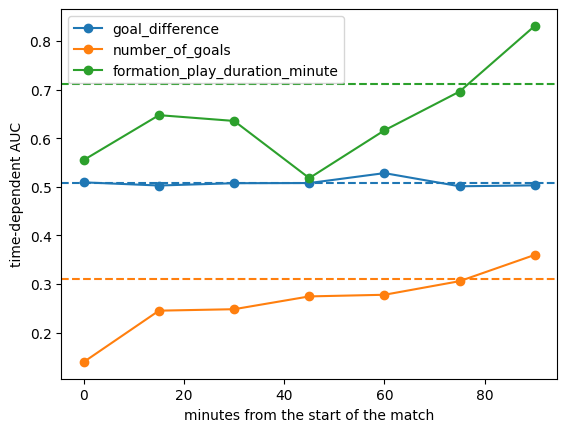

In [21]:
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc

def plot_cumulative_dynamic_auc(risk_score, label, times, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("minutes from the start of the match")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()


numerical_columns = ["goal_difference", "number_of_goals", "formation_play_duration_minute"]

for i, col in enumerate(numerical_columns):
    plot_cumulative_dynamic_auc(x_test.loc[:, col], col, TIME_SEGMENTS, color=f"C{i}")
    ret = concordance_index_ipcw(y_train, y_test, x_test.loc[:, col], tau=TIME_SEGMENTS[-1])
    print(ret)

The chart shows that the number_of_goals and the goal_difference variables have no impact to the model prediction score.
On the other hand the formation_play_duration variable has, to some extent, effect on the model prediction especially after 75th minute of the match. 

In [22]:
# Another way how to evaluate model performance and get value for the concordance index.
# Any value greater than 0.7 is considered as good value for the model performance.
rsf.score(x_test, y_test)

0.9005463479234516